# Autoencoder for MNIST
In this notebook you will train an autoencoder for the MNIST dataset which is a dataset of handwritten digits. This is the last exercise where we will provide a structured skeleton. For future exercises, we will only provide the dataset, task as well as a test scenario for you to challenge yourself against your peers on our leaderboards.

## What we will do:

One application of autoencoders is unsupervised pretraining with unlabeled data and then finetuning the encoder with labeled data. This can increase our performance if there is only little labeled data but a lot of unlabeled data available.

In this exercise you use the MNIST dataset with 60,000 images of handwritten digits, but you do not have all the labels available.

You will then train our autoencoder to reproduce the unlabeled images. 

Then you will transfer the pretrained encoder weights and finetune a classifier on the labeled data for classifying the handwritten digits. This is called **transfer learning**.

In [1]:
# For automatic file reloading as usual
%load_ext autoreload
%autoreload 2
%matplotlib inline

## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [2]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_08) is given.

# from google.colab import drive
# import os

"""
gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_08'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
"""

"\ngdrive_path='/content/gdrive/MyDrive/i2dl/exercise_08'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\n"

### Set up PyTorch environment in colab
- (OPTIONAL) Enable GPU via Runtime --> Change runtime type --> GPU
- Uncomment the following cell if you are using the notebook in google colab:

In [3]:
# Optional: install correct libraries in google colab
# !python -m pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchtext==0.12.0+cu113 torchaudio==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !python -m pip install tensorboard==2.8.0 > /dev/null
# !python -m pip install pytorch-lightning==1.6.0


# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os, sys
import shutil
import torch
import torch.nn as nn
from torchvision import transforms
from exercise_code.image_folder_dataset import ImageFolderDataset
from torch.utils.tensorboard import SummaryWriter
from time import sleep
from tqdm import tqdm
from gradient_descent_the_ultimate_optimizer import gdtuo

torch.manual_seed(42)

<div class="alert alert-warning">
    <h3>Note: Google Colab</h3>
    <p>
In case you don't have a GPU, you can run this notebook on Google Colab where you can access a GPU for free, but, of course, you can also run this notebook on your CPU.
         </p>
</div>

In [5]:
device = torch.device("cpu")
print(device)

cpu


## Setup TensorBoard
In exercise 07 you've already learned how to use TensorBoard. Let's use it again to make the debugging of our network and training process more convenient! Throughout this notebook, feel free to add further logs or visualizations to your TensorBoard!

In [6]:
#%load_ext tensorboard
#%tensorboard --logdir lightning_logs --port 6006

# 1. The MNIST Dataset

First, you download the dataset. MNIST is a dataset of 60,000 images depicting handwritten digits. However, as with most datasets, labeling is a costly process and therefore we are left in a pickle.

A good starting point is to label a small subset of your images. You either do this yourself but in this instance we consider the case where you hired another student to do it for you. After writing a labeling tool and some time, you are provided with 300 labeled images of which 100 will be used for training, 100 for validation, and 100 for testing. A problematic small number...

Feel free to define some transforms now or later (you can also pass without any transforms).

**Note**: We do **NOT** apply any transformations to test set at the time of final evaluation on the server.

In [7]:
########################################################################
# TODO: Feel free to define transforms                                 #
########################################################################
transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.ToPILImage(), transforms.ToTensor()])
pass
########################################################################
#                           END OF YOUR CODE                           #
########################################################################

i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
mnist_root = os.path.join(i2dl_exercises_path, "datasets", "mnist")

train_100_dataset = ImageFolderDataset(root=mnist_root,images='train_images.pt',labels='train_labels.pt',force_download=False,verbose=True,transform=transform)
val_100_dataset = ImageFolderDataset(root=mnist_root,images='val_images.pt',labels='val_labels.pt',force_download=False,verbose=True,transform=transform)
test_100_dataset = ImageFolderDataset(root=mnist_root,images='test_images.pt',labels='test_labels.pt',force_download=False,verbose=True,transform=transform)

# We also set up the unlabeled images which we will use later
unlabeled_train = ImageFolderDataset(root=mnist_root,images='unlabeled_train_images.pt',force_download=False,verbose=True,transform=transform)
unlabeled_val = ImageFolderDataset(root=mnist_root,images='unlabeled_val_images.pt',force_download=False,verbose=True,transform=transform)



Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip


The dataset consists of tuples of 28x28 pixel PIL images and a label that is an integer from 0 to 9. 

Let's turn a few of the images into numpy arrays, to look at their shape and visualize them and see if the labels we paid for are correct.

The shape of our greyscale images:  (28, 28)


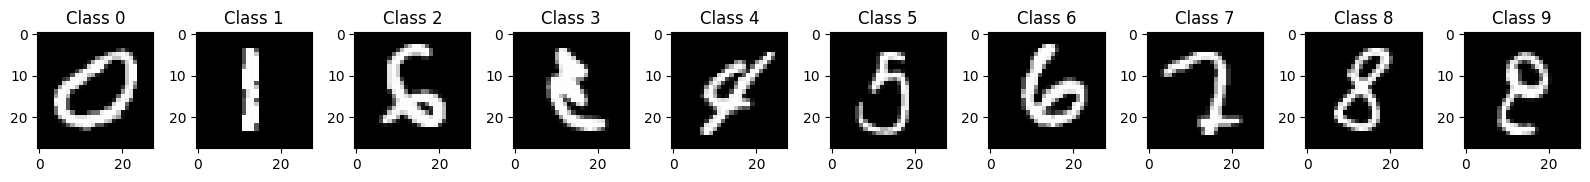

In [8]:
plt.rcParams['figure.figsize'] = (16,16) # Make the figures a bit bigger

indices_arr = [83, 98, 92, 99, 78, 97, 90, 95, 93, 96]
for i, index in enumerate(indices_arr):
    image = np.array(train_100_dataset[index][0].squeeze()) # get the image of the data sample
    label = train_100_dataset[index][1] # get the label of the data sample
    plt.subplot(1, 10, i + 1)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Class {}".format(label))
    
plt.tight_layout()
print('The shape of our greyscale images: ', image.shape)

<div class="alert alert-warning">
    <h3>Note: Starting Simple</h3>
    <p>
Regardless of the size of our dataset, the first step we have to take is to evaluate the performance of a simple classifier. Always approach a problem with a simple approach first and go from there to see which changes are helping you.
         </p>
</div>

# 2. A Simple Classifier

In `exercise_code/models.py` we prepared all classes for you which you will finalize throughout the notebook to build an Autoencoder and an image classifier with PyTorch.

![network_split](img/network_split.png)

## 2.1 The Encoder

Different to previous models, we are going to split up our model into two parts: the so called `encoder` and the `classifier`. The `classifier` has a static task as it will output our predictions given a one-dimensional input. The `encoder`'s task is to extract meaningful information out of our input so that the classifier can make a proper decision. Right now however, both networks will be consisting of linear layers coupled with auxiliary ones and therefore won't be too different in their design. This split-up will be relevant later, e.g., by using convolutional layers which are introduced in the lecture. We are going to set up the `encoder` now. 

Think about a good network architecture. You're completely free here and can come up with any network you like! (\*)

Have a look at the documentation of `torch.nn` at https://pytorch.org/docs/stable/nn.html to learn how to use this module to build your network!

Then implement your architecture: initialize it in `__init__()` and assign it to `self.model`. This is particularly easy using `nn.Sequential()` which you only have to pass the list of your layers. 

To make your model customizable and support parameter search, don't use hardcoded hyperparameters - instead, pass them as dictionary `hparams` (here, `n_hidden` is the number of neurons in the hidden layer) when initializing `models`.

Here's an simple example:

```python
self.model = nn.Sequential(
    nn.Linear(input_size, self.hparams["n_hidden"]),
    nn.ReLU(),
    nn.Linear(self.hparams["n_hidden"], num_classes))
```

Have a look at the forward path in `forward(self, x)`, which is so easy that you don't need to implement it yourself.

As PyTorch automatically computes the gradients, that's all we need to do! No need to manually calculate derivatives for the backward paths anymore! :)


____
\* *The size of your final model must be less than 20 MB, which is approximately equivalent to 5 Mio. params. Note that this limit is quite lenient, you will probably need much less parameters!*

*In order to keep things simple, you should only use fully connected layers for this task as we need to revert the encoder architecture  later on in the notebook.*

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Encoder</code> class initialization in <code>exercise_code/models.py</code>.
    </p>
</div>

## 2.2 The Classifier

Now we are implementing our classifier. It will use the encoder network that you have defined in the above cell. By looking at `Classifier.forward`, you can see that we are simply chaining the `classifier` as well as the `encoder` together. Therefore, you have to match the input shape of the classifier to the output shape of your encoder implemented above. 

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>1. Implement the <code>Classifier</code> class network initialization in <code>exercise_code/models.py</code>.
    </p>
    <p>2. Define in the next cell your hyperparameters in a dictionary called 'hparams'.
    </p>
</div>

In [9]:
########################################################################
# TODO: Define your hyper parameters here!                             #
########################################################################
hparams = {
    "n_hidden_encoder": 520,
    "n_hidden_decoder": 256,
    "n_hidden": 256,
    "num_classes": 10,
    "batch_size": 32,
    "learning_rate": 1e-3,
    "weight_decay": 1e-5,
    "scheduler_factor": 0.1,
    "scheduler_patience": 1
}
pass

########################################################################
#                           END OF YOUR CODE                           #
########################################################################


## 2.3 Optimizer
Lastly, implement the function `set_optimizer` to define your optimizer. Here the documentation of `torch.optim` at https://pytorch.org/docs/stable/optim.html might be helpful.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>set_optimizer</code> method of the <code>Classifier</code> in <code>exercise_code/models.py</code>.
    </p>
</div>


## 2.4 Training & Validation Step

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p> Have a look at the following training pipeline. We explictly write it here fully, so you could learn how it should look like, and also refrence it when in doubt.
 </p>
</div>


In [31]:
 # One of the most crucial things in deep learning is to understand the training pipeline:
 # 1. Forward()          --> The forward pass of the network, to calculate the currnent loss.
 # 2. Backward()         --> The backward pass of the network, to calculate the gradients w.r.t the loss, calculated in the previous stage.
 # 3. Optimizer_step()   --> Update the weights w.r.t thier corresponding gradients and the learnign rate.

def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable),total=len(iterable), ncols=150, desc=desc, leave=False)


def train_classifier(classifier, train_loader, val_loader, loss_func, tb_logger, epochs=10, name="default"):
    """
    Train the classifier for a number of epochs.
    """
    optimizer = classifier.optimizer
    training_loss = 0
    validation_loss = 0
    for epoch in range(epochs):
        
        # Training stage, where we want to update the parameters.
        classifier.train()  # Set the model to training mode
        
        # Create a progress bar for the training loop.
        training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch}/{epochs}]')
        for train_iteration, batch in training_loop:
            optimizer.zero_grad() # Reset the gradients - VERY important! Otherwise they accumulate.
            images, labels = batch # Get the images and labels from the batch, in the fashion we defined in the dataset and dataloader.
            images, labels = images.to(device), labels.to(device) # Send the data to the device (GPU or CPU) - it has to be the same device as the model.

            # Flatten the images to a vector. This is done because the classifier expects a vector as input.
            # Could also be done by reshaping the images in the dataset.
            images = images.view(images.shape[0], -1) 

            pred = classifier(images) # Stage 1: Forward().
            loss = loss_func(pred, labels) # Compute the loss over the predictions and the ground truth.
            loss.backward()  # Stage 2: Backward().
            optimizer.step() # Stage 3: Update the parameters.

            if epoch == epochs - 1: # Save the last epoch's loss.
                training_loss += loss.item()

            # Update the progress bar.
            training_loop.set_postfix(curr_train_loss = "{:.8f}".format(loss.item()), val_loss = "{:.8f}".format(validation_loss))

            # Update the tensorboard logger.
            tb_logger.add_scalar(f'classifier_{name}/train_loss', loss.item(), epoch * len(train_loader) + train_iteration)
            sleep(0.1) # Remove this line if you want to see the progress bar faster.

        # Validation stage, where we don't want to update the parameters. Pay attention to the classifier.eval() line
        # and "with torch.no_grad()" wrapper.
        classifier.eval()
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Epoch [{epoch}/{epochs}]')
        validation_loss = 0
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                images = images.view(images.shape[0], -1) 
                pred = classifier(images)
                loss = loss_func(pred, labels)
                validation_loss += loss.item()

                # Update the progress bar.
                val_loop.set_postfix(curr_val_loss = "{:.8f}".format(loss.item()))

                # Update the tensorboard logger.
                tb_logger.add_scalar(f'classifier_{name}/val_loss', loss.item(), epoch * len(val_loader) + val_iteration)
                sleep(0.1) # Remove this line if you want to see the progress bar faster.
        
        # This value is used for the progress bar of the training loop.
        validation_loss /= len(val_loader)
            

## 2.5 Fit Classification Model with Trainer
Now it's time to train your model.
Run the following cell to see the behold the magic of deep learning at play.

In [32]:
from exercise_code.models import Classifier
from exercise_code.models import Encoder

# Create the encoder and the classifier.
encoder = Encoder(hparams).to(device)
classifier = Classifier(hparams, encoder).to(device)

# Creat a tensorboard logger.
# NOTE: In order to see the logs, run the following command in the terminal: tensorboard --logdir=./
# Also, in order to reset the logs, delete the logs folder MANUALLY.

path = os.path.join('logs', 'cls_logs')
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')

tb_logger = SummaryWriter(path)

# Train the classifier.
labled_train_loader = torch.utils.data.DataLoader(train_100_dataset, batch_size=hparams['batch_size'], shuffle=True)
labled_val_loader = torch.utils.data.DataLoader(val_100_dataset, batch_size=hparams['batch_size'], shuffle=False)

epochs = hparams.get('epochs', 30)
loss_func = nn.CrossEntropyLoss() # The loss function we use for classification.
train_classifier(classifier, labled_train_loader, labled_val_loader, loss_func, tb_logger, epochs=epochs, name="Default")

print("Finished training!")
print("How did we do? Let's check the accuracy of the defaut classifier on the training and validation sets:")
print(f"Training Acc: {classifier.getAcc(labled_train_loader)[1] * 100}%")
print(f"Validation Acc: {classifier.getAcc(labled_val_loader)[1] * 100}%")

Finished training!
How did we do? Let's check the accuracy of the defaut classifier on the training and validation sets:
Training Acc: 49.0%
Validation Acc: 36.0%


# 3. Autoencoder

One hundred images as training data are not much. How could we improve our performance with limited data? We have no money left to pay our student for more labels, and labeling the data ourselves is out of question. A good idea would be to do data augmentation to get the most out of our few labeled instances, but here we provide another way to solve this problem: we will use our large amount of unlabeled data to do unsupervised pretraining with an autoencoder, and then transfer the weights of our encoder to our classifier.

For each image input, the autoencoder just tries to reproduce the same image as output. The difficulty behind is that the autoencoder has to go through a low dimensional bottleneck, which we call the **latent space**.
In other words, the autoencoder should learn to represent all the input information in the low dimensional latent space; it learns to compress the input distribution.
To make our model learn to reproduce the input, we use the mean squared error between our input pixels and the
output pixels as the loss function. For this loss we do not need any labels!

![autoencoder](img/autoencoder.png)

After this, our encoder has learned to extract meaningful information from the inputs. We can then transfer its weights
to a classifier architecture and finetune it with our labeled data, i.e., instead of initializing our encoder randomly we are re-using the weights of our trained encoder from our autoencoder network. This process is called **transfer learning**.

![autoencoder_pretrained](img/pretrained.png)

## 3.1 Decoder

Before we can train our autoencoder, you have to initialize the your `decoder` architecture. The simplest way is to mirror your encoder architecture which ensure that the `latent space` output of our `encoder` is correctly transformed to our input shape.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Decoder</code> and <code>Autoencoder</code> class initialization in <code>exercise_code/models.py</code>.</p>
    <p>Implemet <code>training_step</code> and <code>validation_step</code> of the autoencoder, following the pipeline we've shown you in train_classifier().</p>
    <p>Note the differences between the classificaiton task, and now the regression task!</p>


</div>

## 3.2 Autoencoder Training

Now, we can train the full autoencoder consisting of both en- and decoder.

In [33]:
from exercise_code.models import Autoencoder, Encoder, Decoder

########################################################################
# TODO: Define your hyperparameters here!                              #
# Hint: use a large batch_size                                         #
########################################################################
hparams = {
    "n_hidden_encoder": 2048,
    "n_hidden_decoder": 1024,
    "batch_size": 32,
    "learning_rate": 1e-3,
    "weight_decay": 1e-5
}
pass

########################################################################
#                           END OF YOUR CODE                           #
########################################################################
encoder_pretrained = Encoder(hparams).to(device)
decoder = Decoder(hparams).to(device)
autoencoder = Autoencoder(hparams, encoder_pretrained, decoder).to(device)

Some tests to check whether we'll accept your model.

In [34]:
from exercise_code.Util import printModelInfo, load_model
_ = printModelInfo(autoencoder)

FYI: Your model has 2.474 mio. params.
Model accepted!


After implementing the relevant functions - read the following code, and then run it.
Keep in mind that an epoch here will take much longer since
we are iterating through 5,8600 images instead of just 100.

For speed, colab is indeed recommended. 

In [35]:
encoder_pretrained = Encoder(hparams).to(device)
decoder = Decoder(hparams).to(device)
autoencoder = Autoencoder(hparams, encoder_pretrained, decoder).to(device)

def train_model(model, train_loader, val_loader, loss_func, tb_logger, epochs=10, name='Autoencoder'):
    
    optimizer = model.optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs * len(train_loader) / 5, gamma=0.7)
    validation_loss = 0
    for epoch in range(epochs):
        
        # Train
        training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch}/{epochs}]')
        for train_iteration, batch in training_loop:
            
            loss = model.training_step(batch, loss_func) # You need to implement this function.
            scheduler.step()

            # Update the progress bar.
            training_loop.set_postfix(curr_train_loss = "{:.8f}".format(loss.item()), val_loss = "{:.8f}".format(validation_loss))

            # Update the tensorboard logger.
            tb_logger.add_scalar(f'{name}/train_loss', loss.item(), epoch * len(train_loader) + train_iteration)

        # Validation
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Epoch [{epoch}/{epochs}]')
        validation_loss = 0
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                loss = model.validation_step(batch, loss_func) # You need to implement this function.
                validation_loss += loss.item()

                # Update the progress bar.
                val_loop.set_postfix(curr_val_loss = "{:.8f}".format(loss.item()))

                # Update the tensorboard logger.
                tb_logger.add_scalar(f'{name}/val_loss', loss.item(), epoch * len(val_loader) + val_iteration)

        # This value is for the progress bar of the training loop.
        validation_loss /= len(val_loader)

# Creat a tensorboard logger.
# NOTE: In order to see the logs, run the following command in the terminal: tensorboard --logdir=./
# Also, in order to reset the logs, delete the logs folder MANUALLY.

path = os.path.join('logs', 'ae_logs')
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')
tb_logger = SummaryWriter(path)

# Train the classifier.
unlabled_train_loader = torch.utils.data.DataLoader(unlabeled_train, batch_size=hparams['batch_size'], shuffle=True)
unlabled_val_loader = torch.utils.data.DataLoader(unlabeled_val, batch_size=hparams['batch_size'], shuffle=False)

epochs = hparams.get('epochs', 20)
loss_func = nn.MSELoss() # The loss function we use for regression (Could also be nn.L1Loss()).
train_model(autoencoder, unlabled_train_loader, unlabled_val_loader, loss_func, tb_logger, epochs=epochs, name='Autoencoder')

print("Finished training!")

Finished training!


Once trained, let's have a look at the reconstructed validation images (If you have not already looked at them in TensorBoard).

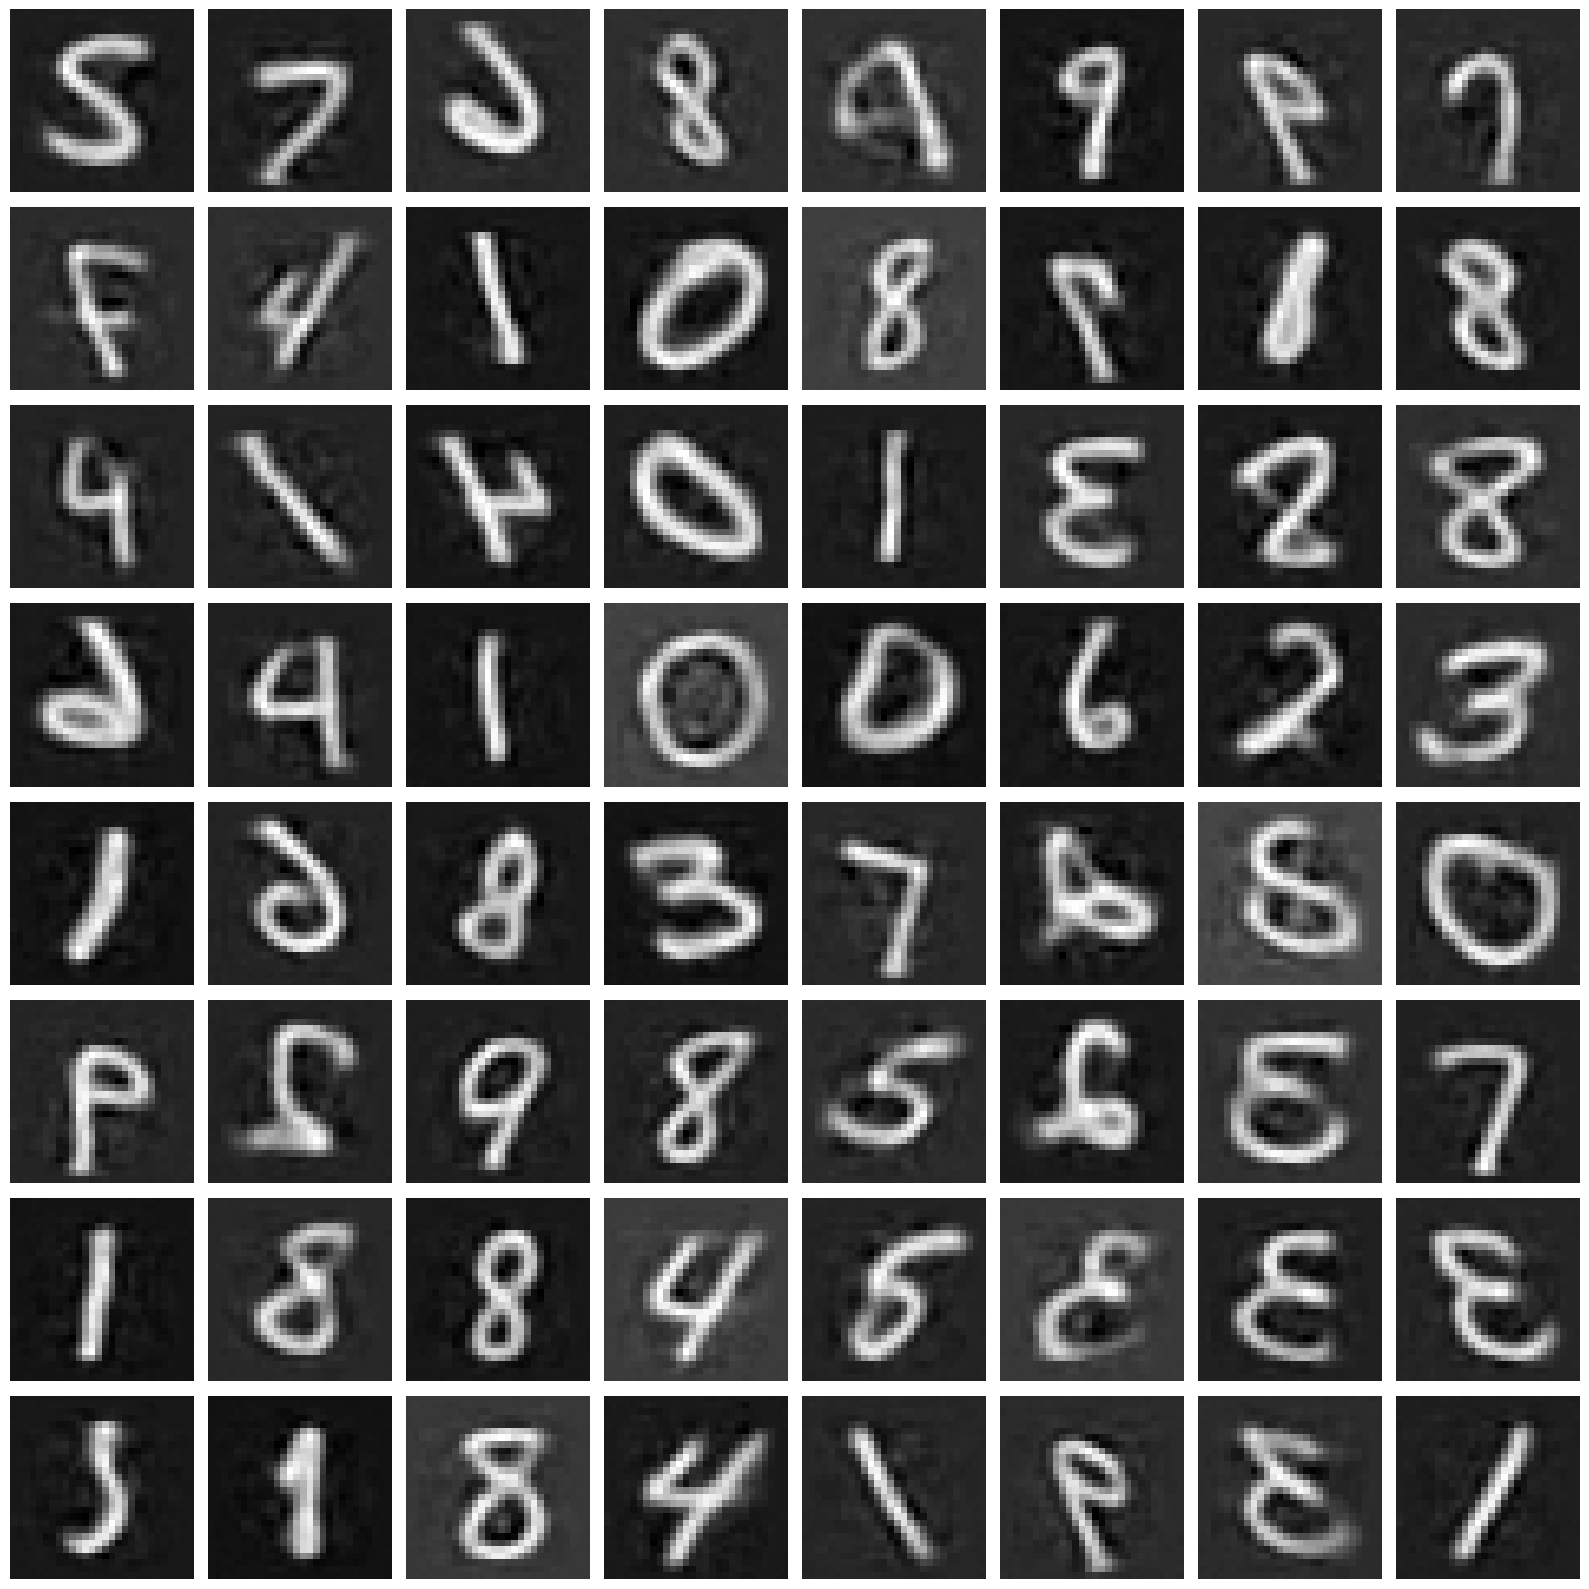

In [36]:
reconstructions = autoencoder.getReconstructions(unlabled_val_loader)
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.imshow(reconstructions[i], cmap='gray', interpolation='none')
    
plt.tight_layout()

# 4. Transfer Learning

## 4.1 The pretrained Classifier

Now we initialize another classifier but this time with the pretrained encoder.

In [37]:
from exercise_code.models import Classifier
from copy import deepcopy

########################################################################
# TODO: Define your hyper parameters here!                             #
########################################################################
hparams = {
    "n_hidden": 2048,
    "batch_size": 32,
    "learning_rate": 1e-2,
    "weight_decay": 1e-5,
    "scheduler_factor": 0.001,
    "scheduler_patience": 2,
    "num_classes": 10
}
pass

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

encoder_pretrained_copy = deepcopy(encoder_pretrained)
classifier_pretrained = Classifier(hparams, encoder_pretrained_copy).to(device)

Now specify another trainer that we will use the pretrained classifier to compare its performance with
the classifier we trained on only the labeled data. You might need to optimize the parameters defined above in order to achieve a reasonable result.

In [38]:

# Creat a tensorboard logger.
# NOTE: In order to see the logs, run the following command in the terminal: tensorboard --logdir=./
# Also, in order to reset the logs, delete the logs folder MANUALLY.
# Pay attention that if you run this cell mutltiple times, the pretrained_encoder
# is not reset, and will keep training from where it stopped. Thus, it could overfit.

path = os.path.join('logs', 'pretrained_cls_logs')
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')
tb_logger = SummaryWriter(path)

batch_size = hparams.get('batch_size', 16)
labled_train_loader = torch.utils.data.DataLoader(train_100_dataset, batch_size=batch_size, shuffle=True)
labled_val_loader = torch.utils.data.DataLoader(val_100_dataset, batch_size=batch_size, shuffle=False)

epochs = hparams.get('epochs', 30)
loss_func = nn.CrossEntropyLoss() # The loss function we use for classification.
train_classifier(classifier_pretrained, labled_train_loader, labled_val_loader, loss_func, tb_logger, epochs=epochs, name='Pretrained')

print("Finished training!") 

Finished training!


Let's have a look at the validation accuracy of the two different classifiers and compare them. And don't forget that you can also monitor your training in TensorBoard.

We will only look at the test accuracy and compare our two classifiers with respect to that in the very end.

In [39]:
print("Validation accuracy when training from scratch: {}%".format(classifier.getAcc(labled_val_loader)[1]*100))
print("Validation accuracy with pretraining: {}%".format(classifier_pretrained.getAcc(labled_val_loader)[1]*100))

Validation accuracy when training from scratch: 34.0%
Validation accuracy with pretraining: 68.0%


Now that everything is working, feel free to play around with different architectures. As you've seen, it's really easy to define your model or do changes there.

To pass this submission, you'll need an accuracy of **55%**.

# Save your model & Report Test Accuracy

When you've done with your **hyperparameter tuning**, have achieved **at least 55% validation accuracy** and are happy with your final model, you can save it here.

Before that, please check again whether the number of parameters is below 5 Mio and the file size is below 20 MB.

When your final model is saved, we'll lastly report the test accuracy.

In [40]:
from exercise_code.Util import test_and_save
test_dl = torch.utils.data.DataLoader(test_100_dataset, batch_size=4, shuffle=False)
print("Test accuracy when training from scratch: {}%".format(classifier.getAcc(test_dl)[1]*100))
print('\nNow to the pretrained classifier:')
test_and_save(classifier_pretrained, labled_val_loader, test_dl)

Test accuracy when training from scratch: 39.0%

Now to the pretrained classifier:
Validation-Accuracy: 68.0%
Your model has 5.909 mio. params but must have less than 5 mio. params. Simplify your model before submitting it. You won't need that many params :)


In [41]:
# Now zip the folder for upload
from exercise_code.submit import submit_exercise

submit_exercise('../output/exercise_08')

relevant folders: ['exercise_code', 'models']
notebooks files: ['1_Autoencoder.ipynb', 'Optional-BatchNormalization_Dropout.ipynb']
Adding folder exercise_code
Adding folder models
Adding notebook 1_Autoencoder.ipynb
Adding notebook Optional-BatchNormalization_Dropout.ipynb
Zipping successful! Zip is stored under: /Users/guangyaoquan/Downloads/i2dl/output/exercise_08.zip


Congrats! You've now finished your first autoencoder and transferred the weights to a classifier! Much easier than in plain numpy, right? But wait, to complete the exercise, submit your final model to [our submission portal](https://i2dl.dvl.in.tum.de/) - you should be already familiar with the procedure. Next, it is time to get started with some more complex neural networks and tasks in the upcoming exercises. See you next week!

# Submission Goals

- Goal: Successfully implement a fully connected autoencoder for MNIST with Pytorch Lightning and transfer the encoder weights to a classifier.

- Passing Criteria: There are no unit tests that check specific components of your code. The only thing that's required to pass the submission, is your model to reach at least **55% accuracy** on __our__ test dataset. The submission system will show you a number between 0 and 100 which corresponds to your accuracy.

- Submission start: __December 15, 2022 13.00__
- Submission deadline : __December 21, 2022 15.59__ 
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus.

# [Exercise Review](https://forms.gle/9SYivCPQZdktRDS29)

We are always interested in your opinion. Now that you have finished this exercise, we would like you to give us some feedback about the time required to finish the submission and/or work through the notebooks. Please take the short time to fill out our [review form](https://forms.gle/9SYivCPQZdktRDS29) for this exercise so that we can do better next time! :)